In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import reservoirpy as rpy
import json
import math

from sklearn.model_selection import train_test_split
from IPython.display import display
from reservoirpy.observables import mse
from reservoirpy.nodes import Reservoir, Ridge, Input
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from reservoirpy.observables import nrmse, rsquare, mse, rmse

# Se importan los datos del txt

In [23]:
# Importar los datos

# Guarda los nombres únicos de las primeras dos columnas.
index_col_names=['unit_id','time_cycle']
# Genera los nombres del primer set de columnas con formato, estas son las de operational setting n.
operat_set_col_names=['oper_set{}'.format(i) for i in range(1,4)]
# Genera los nombres del segundo set de columnas con formato, estas son las de sensor measurement n.
sensor_measure_col_names=['sm_{}'.format(i) for i in range(1,22)]
# Pone todos los títulos en una lista
all_col=index_col_names+operat_set_col_names+sensor_measure_col_names

# Importa los datos desde el .txt com su nombre de columna en un dataframe.
train_df=pd.read_csv('train.txt',delim_whitespace=True,names=all_col)
train_df

C:\Users\dave4\AppData\Local\Temp\ipykernel_4660\1475424004.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df=pd.read_csv('train.txt',delim_whitespace=True,names=all_col)


,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,...,130.21,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,...,130.24,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,...,129.86,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,...,182.03,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761


# Calcular el tiempo hasta el fallo (RUL)

In [24]:
# Primero se encuentra el ciclo de tiempo máximo para cada motor.
max_time_cycle=train_df.groupby('unit_id')['time_cycle'].max()

rul = pd.DataFrame(max_time_cycle).reset_index()
rul.columns = ['unit_id', 'max']

# Se calcula el RUL para cada fila con un id específico y se le resta el máximo.
train_df = train_df.merge(rul, on=['unit_id'], how='left')
train_df['RUL'] = train_df['time_cycle'] - train_df['max']
train_df.drop('max', axis=1, inplace=True)
train_df[train_df.unit_id==1].iloc[:,[1,-1]]
train_df

,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21,RUL
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,-222
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,-221
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,-220
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,-219
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,-218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,...,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,-4
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,...,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,-3
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,...,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,-2
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,...,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,-1


##### Aquí se puede ver que los datos del sensor 15 es el que tiene menos correlación con el resto de los sensores

C:\Users\dave4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dave4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dave4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values t

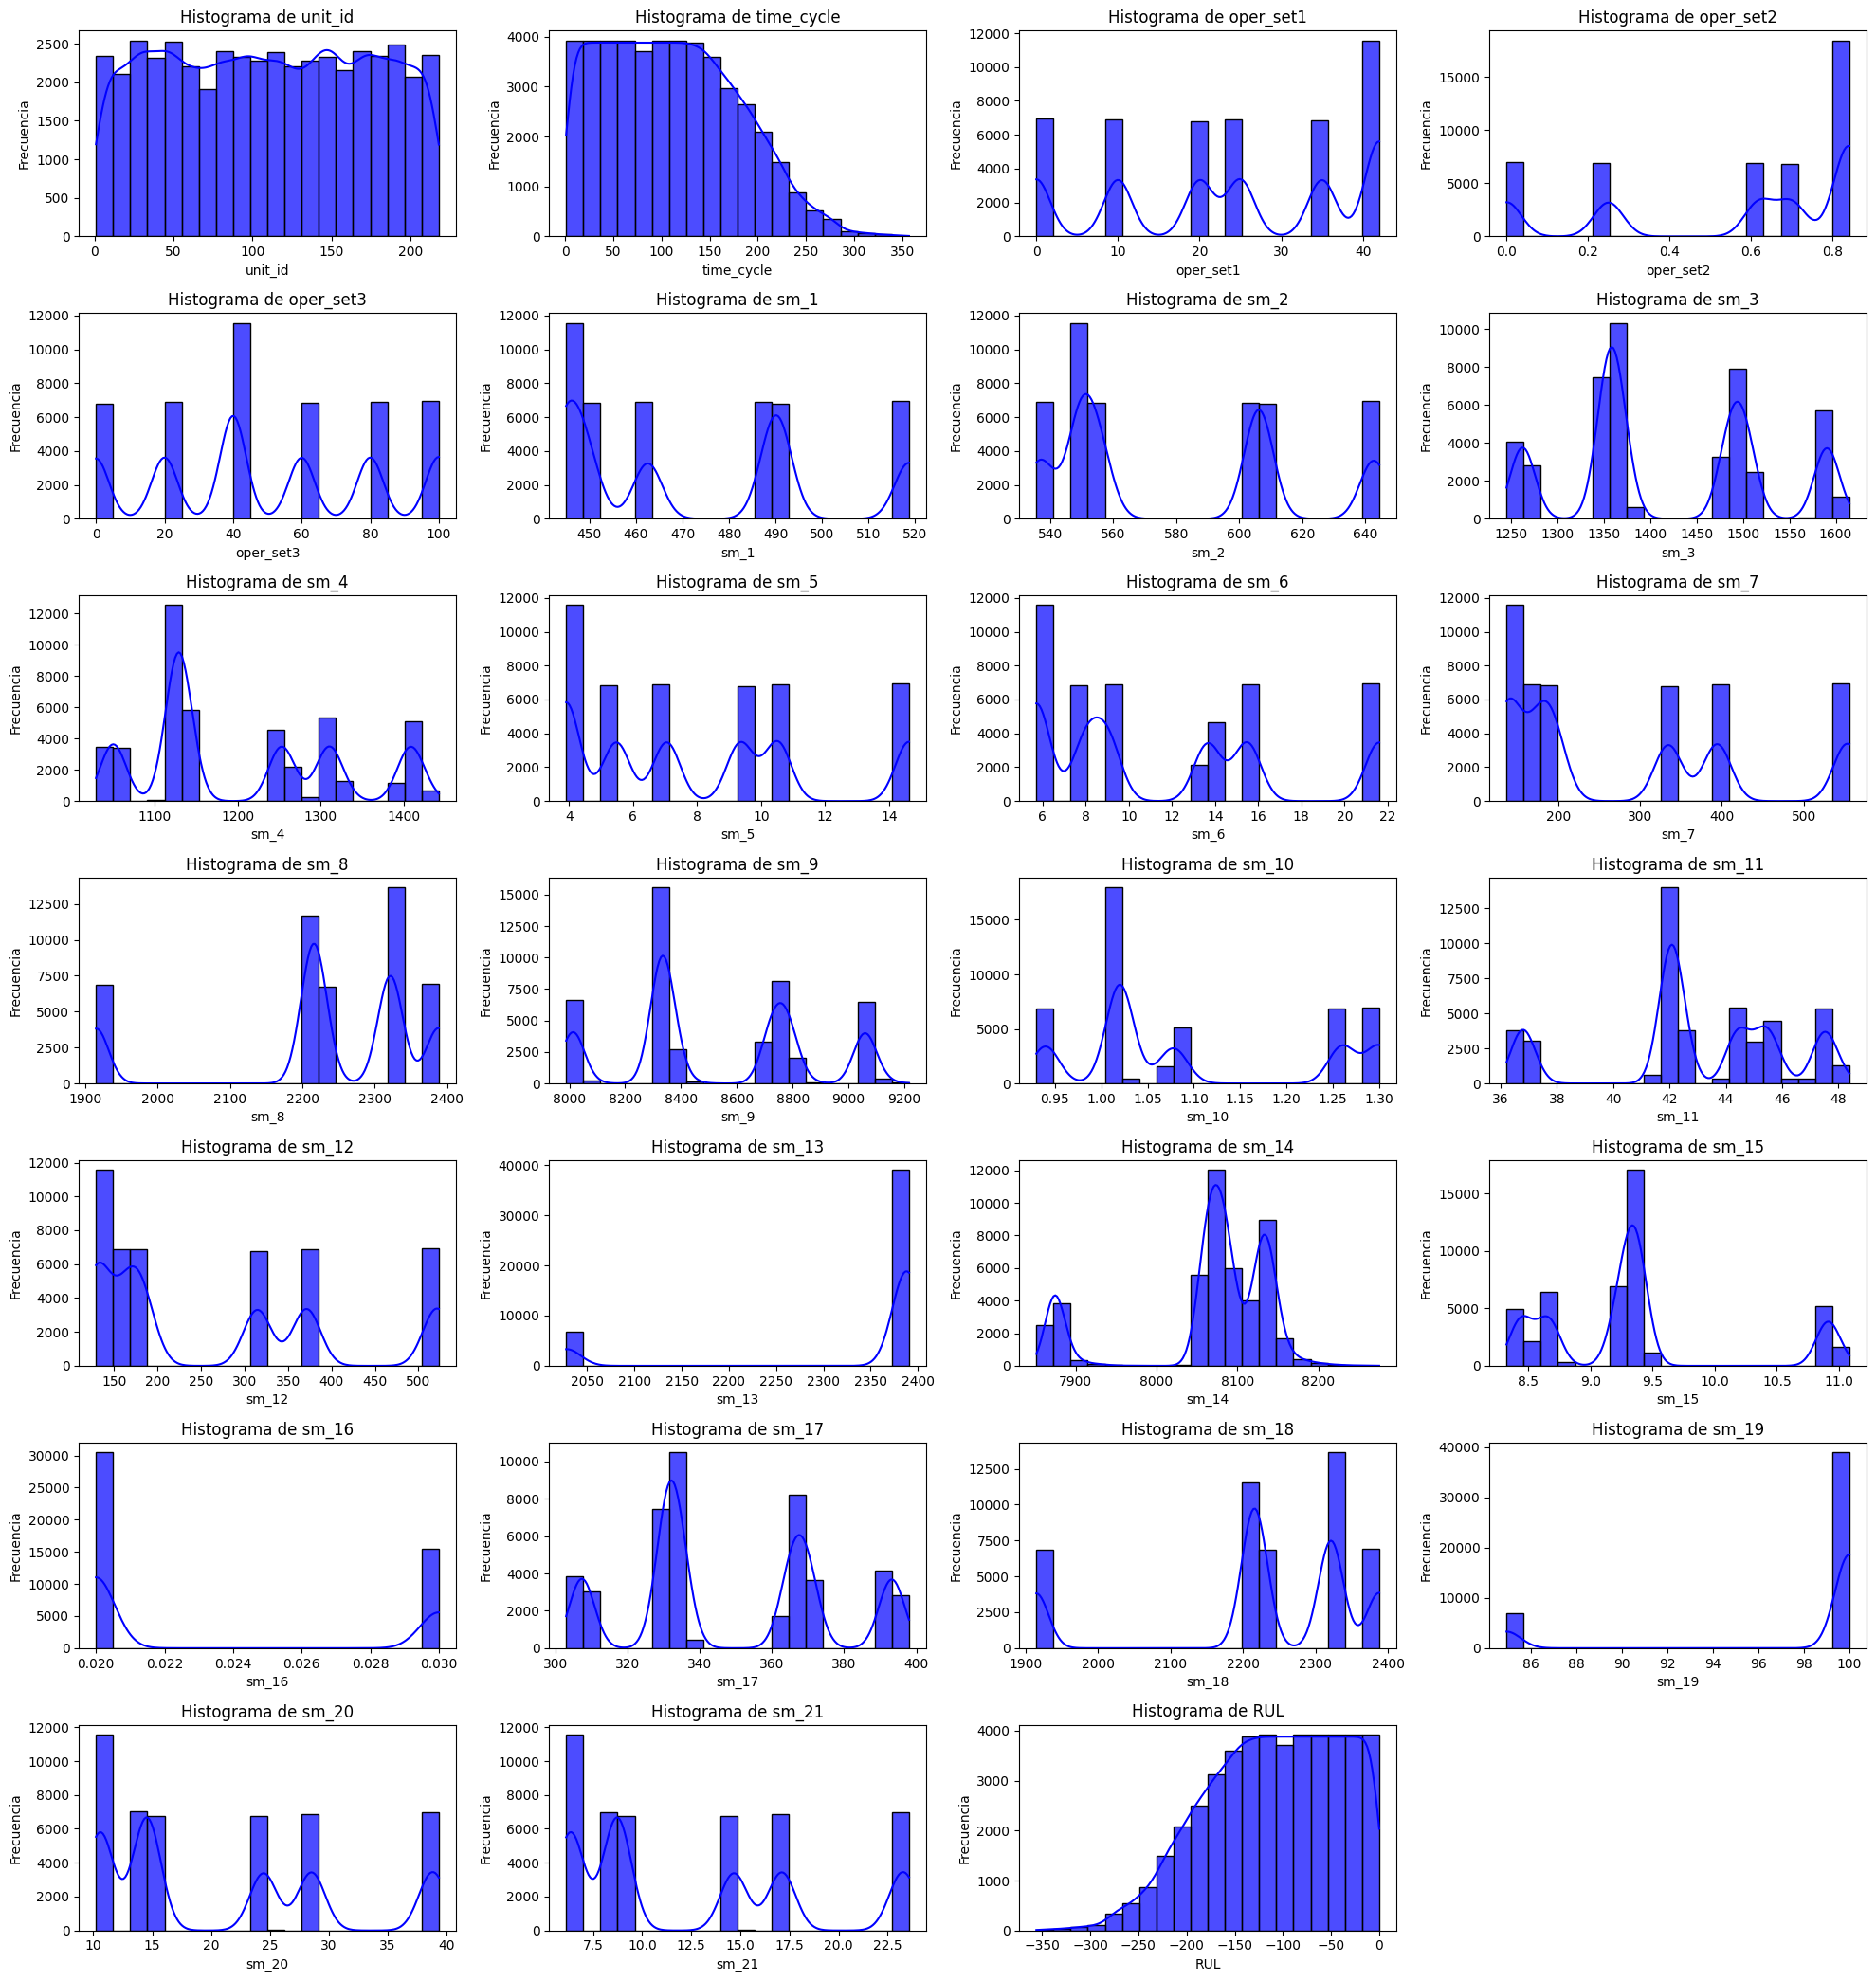

In [14]:
# Configurar el número de filas y columnas para los subgráficos
num_cols = 4  # Número de columnas en el layout
num_rows = len(train_df.columns) // num_cols + (len(train_df.columns) % num_cols > 0)  # Calcular el número de filas

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 3))  # Ajustar el tamaño de las subfiguras

# Crear histogramas para cada columna usando seaborn
for i, col in enumerate(train_df.columns):
    row, col_pos = divmod(i, num_cols)  # Calcular la posición del subgráfico
    sns.histplot(train_df[col], bins=20, kde=True, ax=axs[row, col_pos], color='blue', alpha=0.7)  # Crear histograma
    axs[row, col_pos].set_title(f'Histograma de {col}')  # Título del histograma
    axs[row, col_pos].set_xlabel(col)  # Etiqueta del eje x
    axs[row, col_pos].set_ylabel('Frecuencia')  # Etiqueta del eje y

# Ajustar el layout
plt.tight_layout()

# Eliminar subgráficos vacíos si es necesario
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.show()  # Mostrar la figura

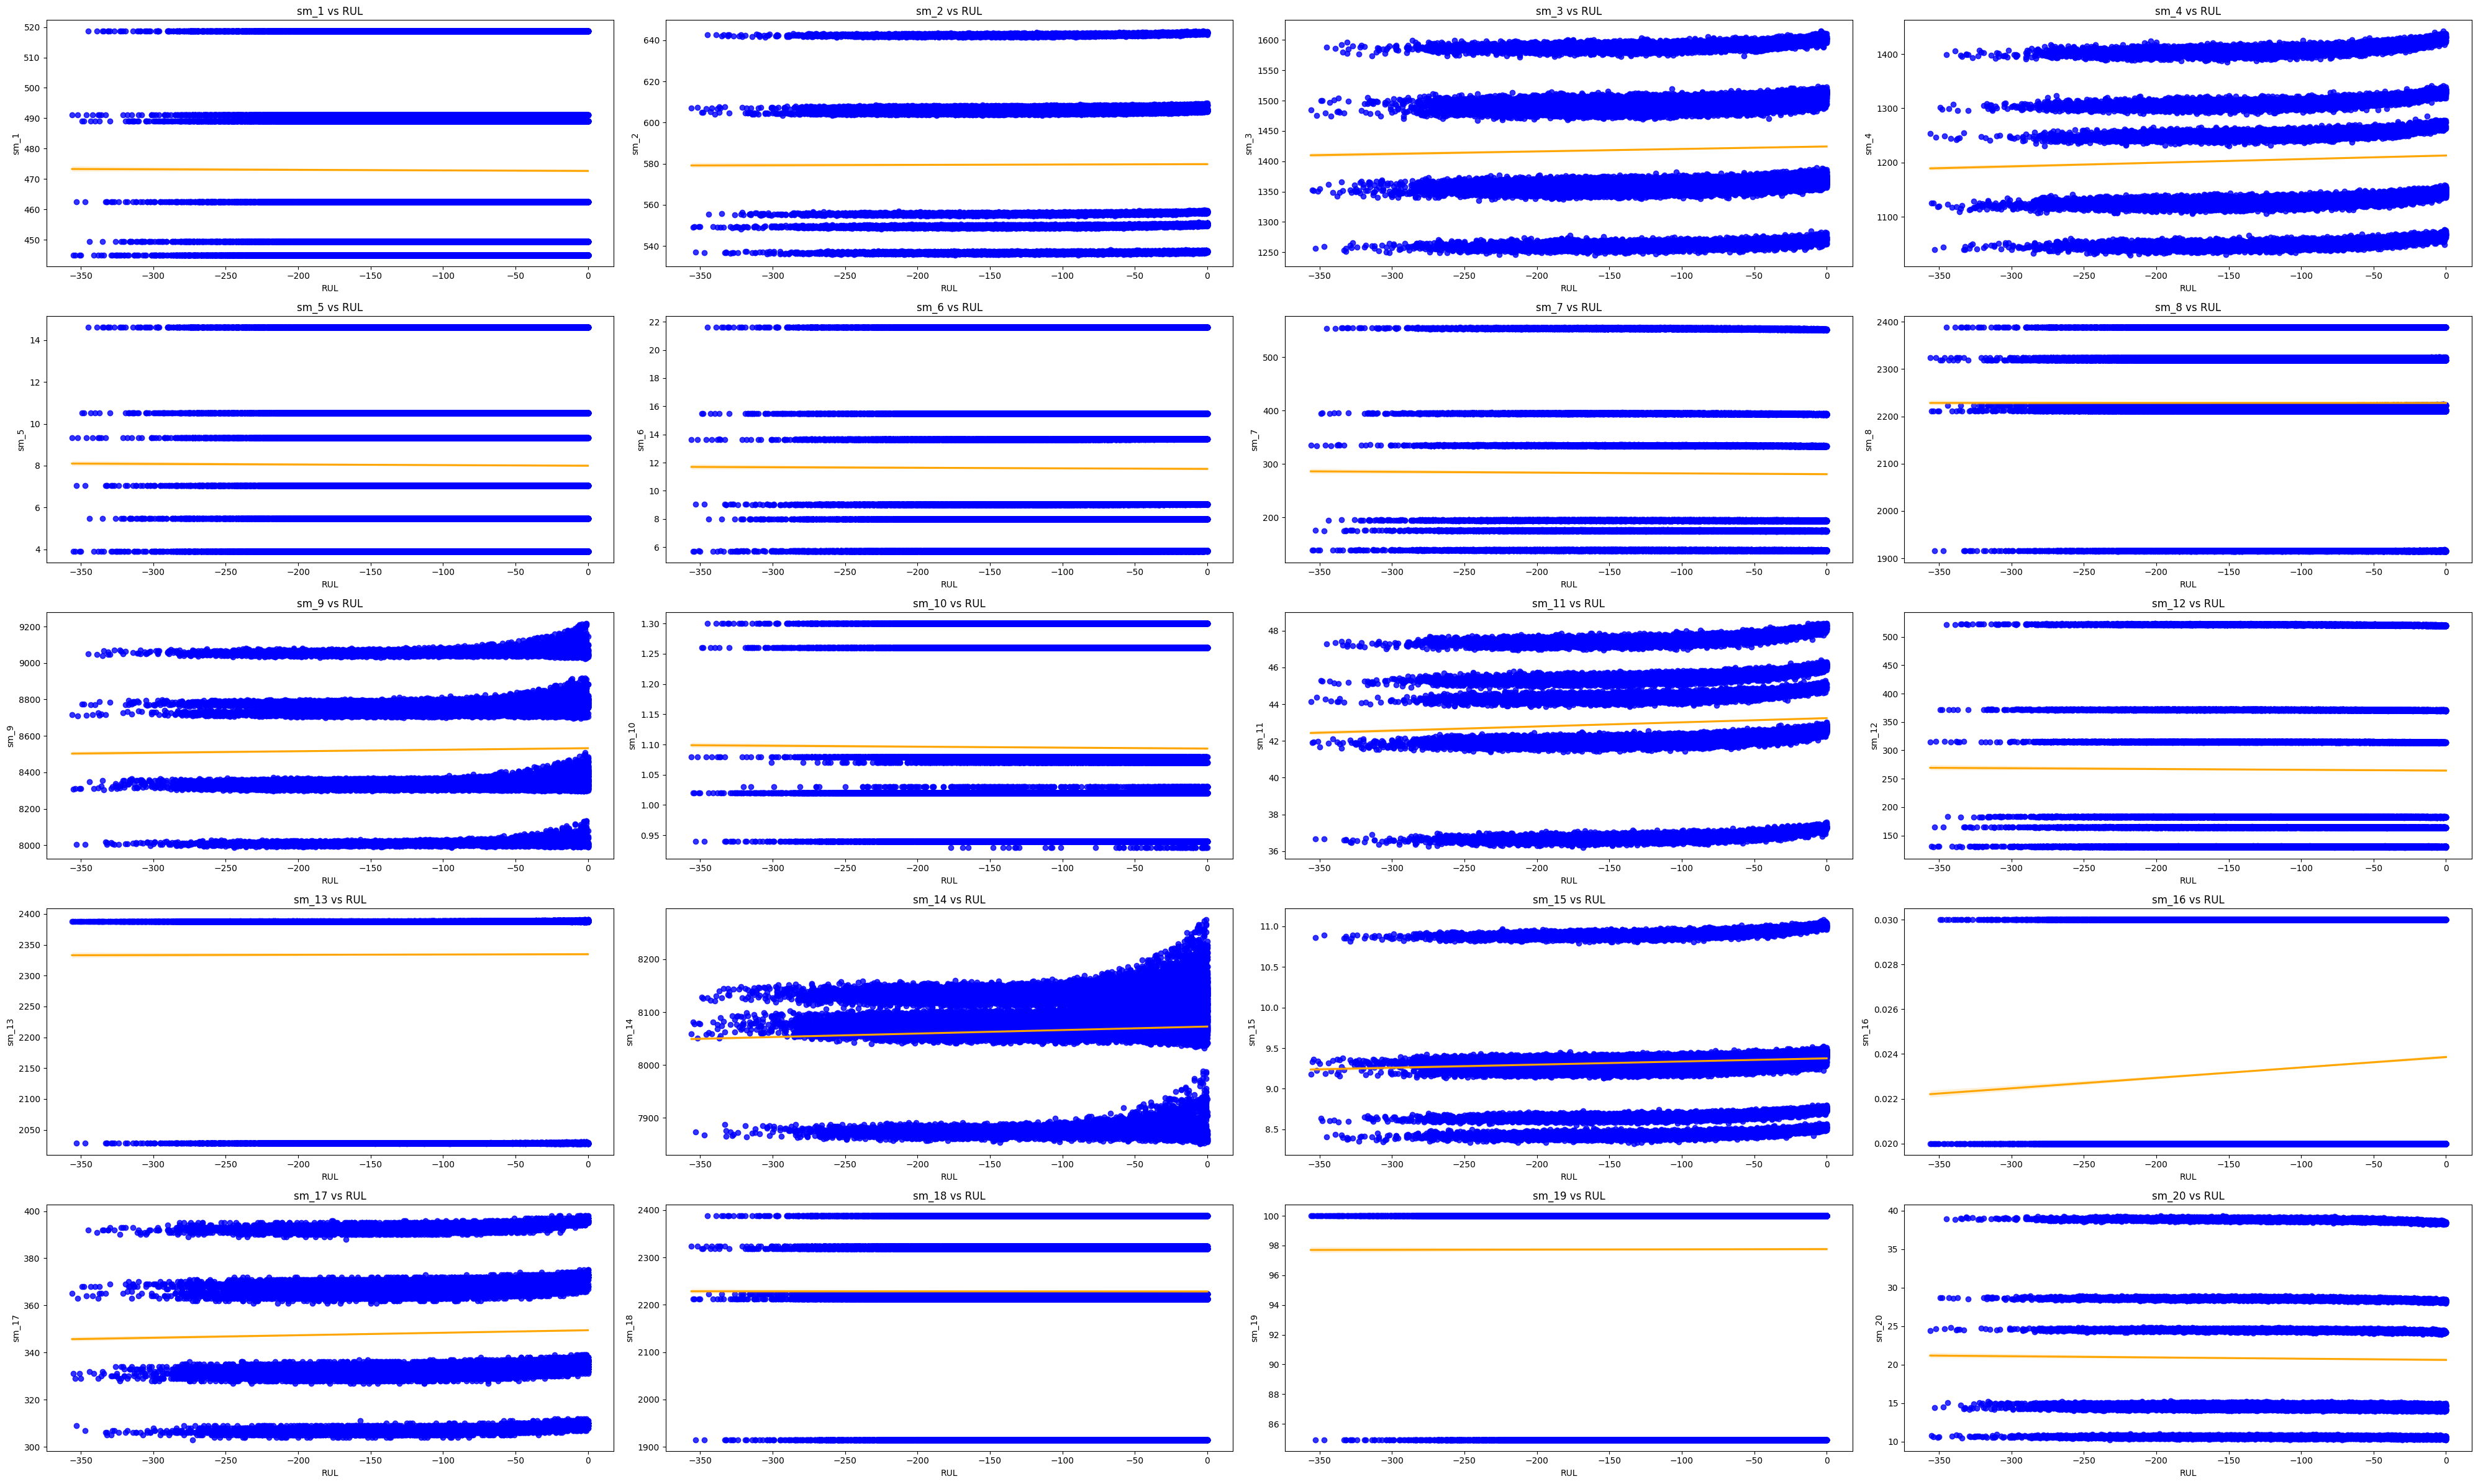

In [15]:
num_cols = 4  # Número de columnas en la figura
num_rows = len(train_df.columns[5:-2]) // num_cols + (len(train_df.columns[5:-2]) % num_cols > 0)  # Se calcula el número de filas

fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 24))  # # Ajustar el tamaño de las subfiguras

# Se crea el scatter plot de cada sensor contra el RUL
for i, col in enumerate(train_df.columns[5:-2]):  # Se exclude la columna de RUL
    row, col_pos = divmod(i, num_cols)  # Se calcula la posición del subplot en la figura
    
    # Se dibuja el scatterplot y la línea de tendencia
    sns.regplot(x=train_df['RUL'], y=train_df[col], ax=axs[row, col_pos],
                scatter_kws={'color': 'blue', 'marker': 'o'},  # Personalización del scatter plot
                line_kws={'color': 'orange'})  # Personalización de la linea de tendencia
    
    axs[row, col_pos].set_title(f'{col} vs RUL')  # Título del plot
    axs[row, col_pos].set_xlabel('RUL')  # Etiqueta del eje X
    axs[row, col_pos].set_ylabel(col)  # Etiqueta del eje Y

plt.tight_layout()

# Se remueven los plots vacíos, si es necesario
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.show()

##### Se puede observar que los sensores 19, 16 y 3 son los que tienen poca variación, por lo tanto aportan poco a la predicción

# Normalizar con respecto a los ciclos hasta el fallo

In [ ]:
def preprocess_data(df, feature_columns):
    """
    Preprocesar los datos reemplazando los valores NaN y luego normalizándola
    
    Parameters:
    - df: Dataframe que contiene los datos
    - feature_columns: lista de los índices de columnas de los features

    Returns:
    - Arreglo de features procesado
    """
    # Se extraen valores relevantes del DataFrame
    X = df.values[:, feature_columns]
    
    # Se reeemplazan los NaN con ceros
    X = np.nan_to_num(X)
    
    return X

def perform_clustering(X, n_clusters=6, n_init=12):
    """
    Hacer ke K-Clustering
    
    Parameters:
    - X: Arreglo de los features
    - n_clusters: Número de clusters a formar
    - n_init: Cantidad de veces que se ejecutará el algoritmo K-Means con diferentes semillas de centroides.

    Returns:
    - labels: Etiquetas de cluster para cada punto en el conjunto de datos
    """
    # Crear un pipeline para normalización y clustering
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(init="k-means++", n_clusters=n_clusters, n_init=n_init))
    ])
    
    # Hacer el fit del pipeline a los datos
    pipeline.fit(X)
    
    return pipeline.named_steps['kmeans'].labels_

# Determinar cuáles columnas de los features se utilizarán (estas corresponden a las de operational settings)
feature_columns = slice(2, 5)

# Preprocesado de los datos
X_processed = preprocess_data(train_df, feature_columns)

# Se hace el clustering
train_df['Clus_op'] = perform_clustering(X_processed)

# Mostrar el dataframe nuevo con los datos agregados
train_df

,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21,RUL,Clus_op
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,-222,2
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,-221,0
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,-220,5
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,-219,4
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,-218,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,...,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,-4,1
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,...,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,-3,1
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,...,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,-2,1
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,...,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,-1,5


In [ ]:
norm_train_df = train_df

def standardize_sensors_by_cluster(df, sensor_columns):
    """
    Normalizar las lecturas de los sensores basado en los clusters

    Parameters:
    - df: Dataframe que contiene los datos de los sensores con los clusters
    - sensor_columns: Lista de las columnas a normalizar

    Returns:
    - df: Dataframe con los datos de los sensores normalizados
    - scaled_features: Diccionario con el promedio y la desviación estándard para cada sensor en cada cluster
    """
    # Se incializa el diccionario que guarda scaled_features
    scaled_features = {}

    # Hacer grupos por cluster y calcular el promedio y la desvaición para cada sensor.
    for cluster_id, group in df.groupby('Clus_op'):
        for sensor in sensor_columns:
            mean = group[sensor].mean()
            std = group[sensor].std()
            config_name = f"{sensor}_{cluster_id}"  # Nombre de la configuración
            scaled_features[config_name] = [mean, std]  # Se guardan promedio y el std

            # Se normalizan los valores de los sensores
            df.loc[df['Clus_op'] == cluster_id, sensor] = (group[sensor] - mean) / std

    return df, scaled_features

# Lista de los nombres de las columnas de los sensores
sensor_columns = [f'sm_{i + 1}' for i in range(21)]  # Sensor names s1 to s21

# Normalizar los datos con respecto al cluster
norm_train_df, scaled_features = standardize_sensors_by_cluster(norm_train_df, sensor_columns)

# Mostrar el dataset nuevo
norm_train_df


C:\Users\dave4\AppData\Local\Temp\ipykernel_22844\3000717381.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.52016031 -1.52016031 -0.84799176 ...  0.49634534  1.84068245
  1.84068245]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Clus_op'] == cluster_id, sensor] = (group[sensor] - mean) / std


,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21,RUL,Clus_op
0,1,1,10.0047,0.2501,20.0,-0.999927,-1.665632,-0.460749,-0.168926,0.999927,...,-0.822667,-1.170261,-0.999927,-1.180982,NaN,NaN,0.377638,0.675882,-222,2
1,1,2,0.0015,0.0003,100.0,NaN,-1.201429,-1.040821,-0.626306,-0.999928,...,-0.472019,-1.468330,-0.999928,-1.520160,NaN,NaN,1.036511,0.735170,-221,0
2,1,3,34.9986,0.8401,60.0,0.999927,-0.920577,0.218738,-1.283192,-0.999927,...,-0.461147,0.550747,0.999927,-0.205342,NaN,NaN,0.022284,-0.595856,-220,5
3,1,4,20.0031,0.7005,0.0,0.999926,-1.212605,0.422369,-0.577304,0.999926,...,-0.817049,-0.314185,-0.548699,-1.005683,NaN,NaN,-0.202145,1.411592,-219,4
4,1,5,42.0041,0.8405,40.0,NaN,-0.456453,-0.034709,-0.513961,0.999957,...,-0.286493,-2.132310,NaN,-0.793917,NaN,NaN,3.771104,0.808162,-218,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,NaN,2.959902,1.870111,2.545405,0.999957,...,-1.536422,2.439727,NaN,1.334538,NaN,NaN,-0.126268,-0.823066,-4,1
45914,218,130,42.0029,0.8415,40.0,NaN,0.796211,1.919541,1.854367,0.999957,...,-1.585699,2.296003,NaN,0.625053,NaN,NaN,-1.703776,-1.205777,-3,1
45915,218,131,41.9999,0.8400,40.0,NaN,0.454575,0.800305,2.905486,0.999957,...,-1.544835,2.860051,NaN,2.044023,NaN,NaN,-1.982160,-2.402534,-2,1
45916,218,132,35.0007,0.8419,60.0,0.999927,1.651544,2.319518,1.833844,-0.999927,...,-1.785563,2.268745,0.999927,1.943856,NaN,NaN,-1.132928,-3.193209,-1,5


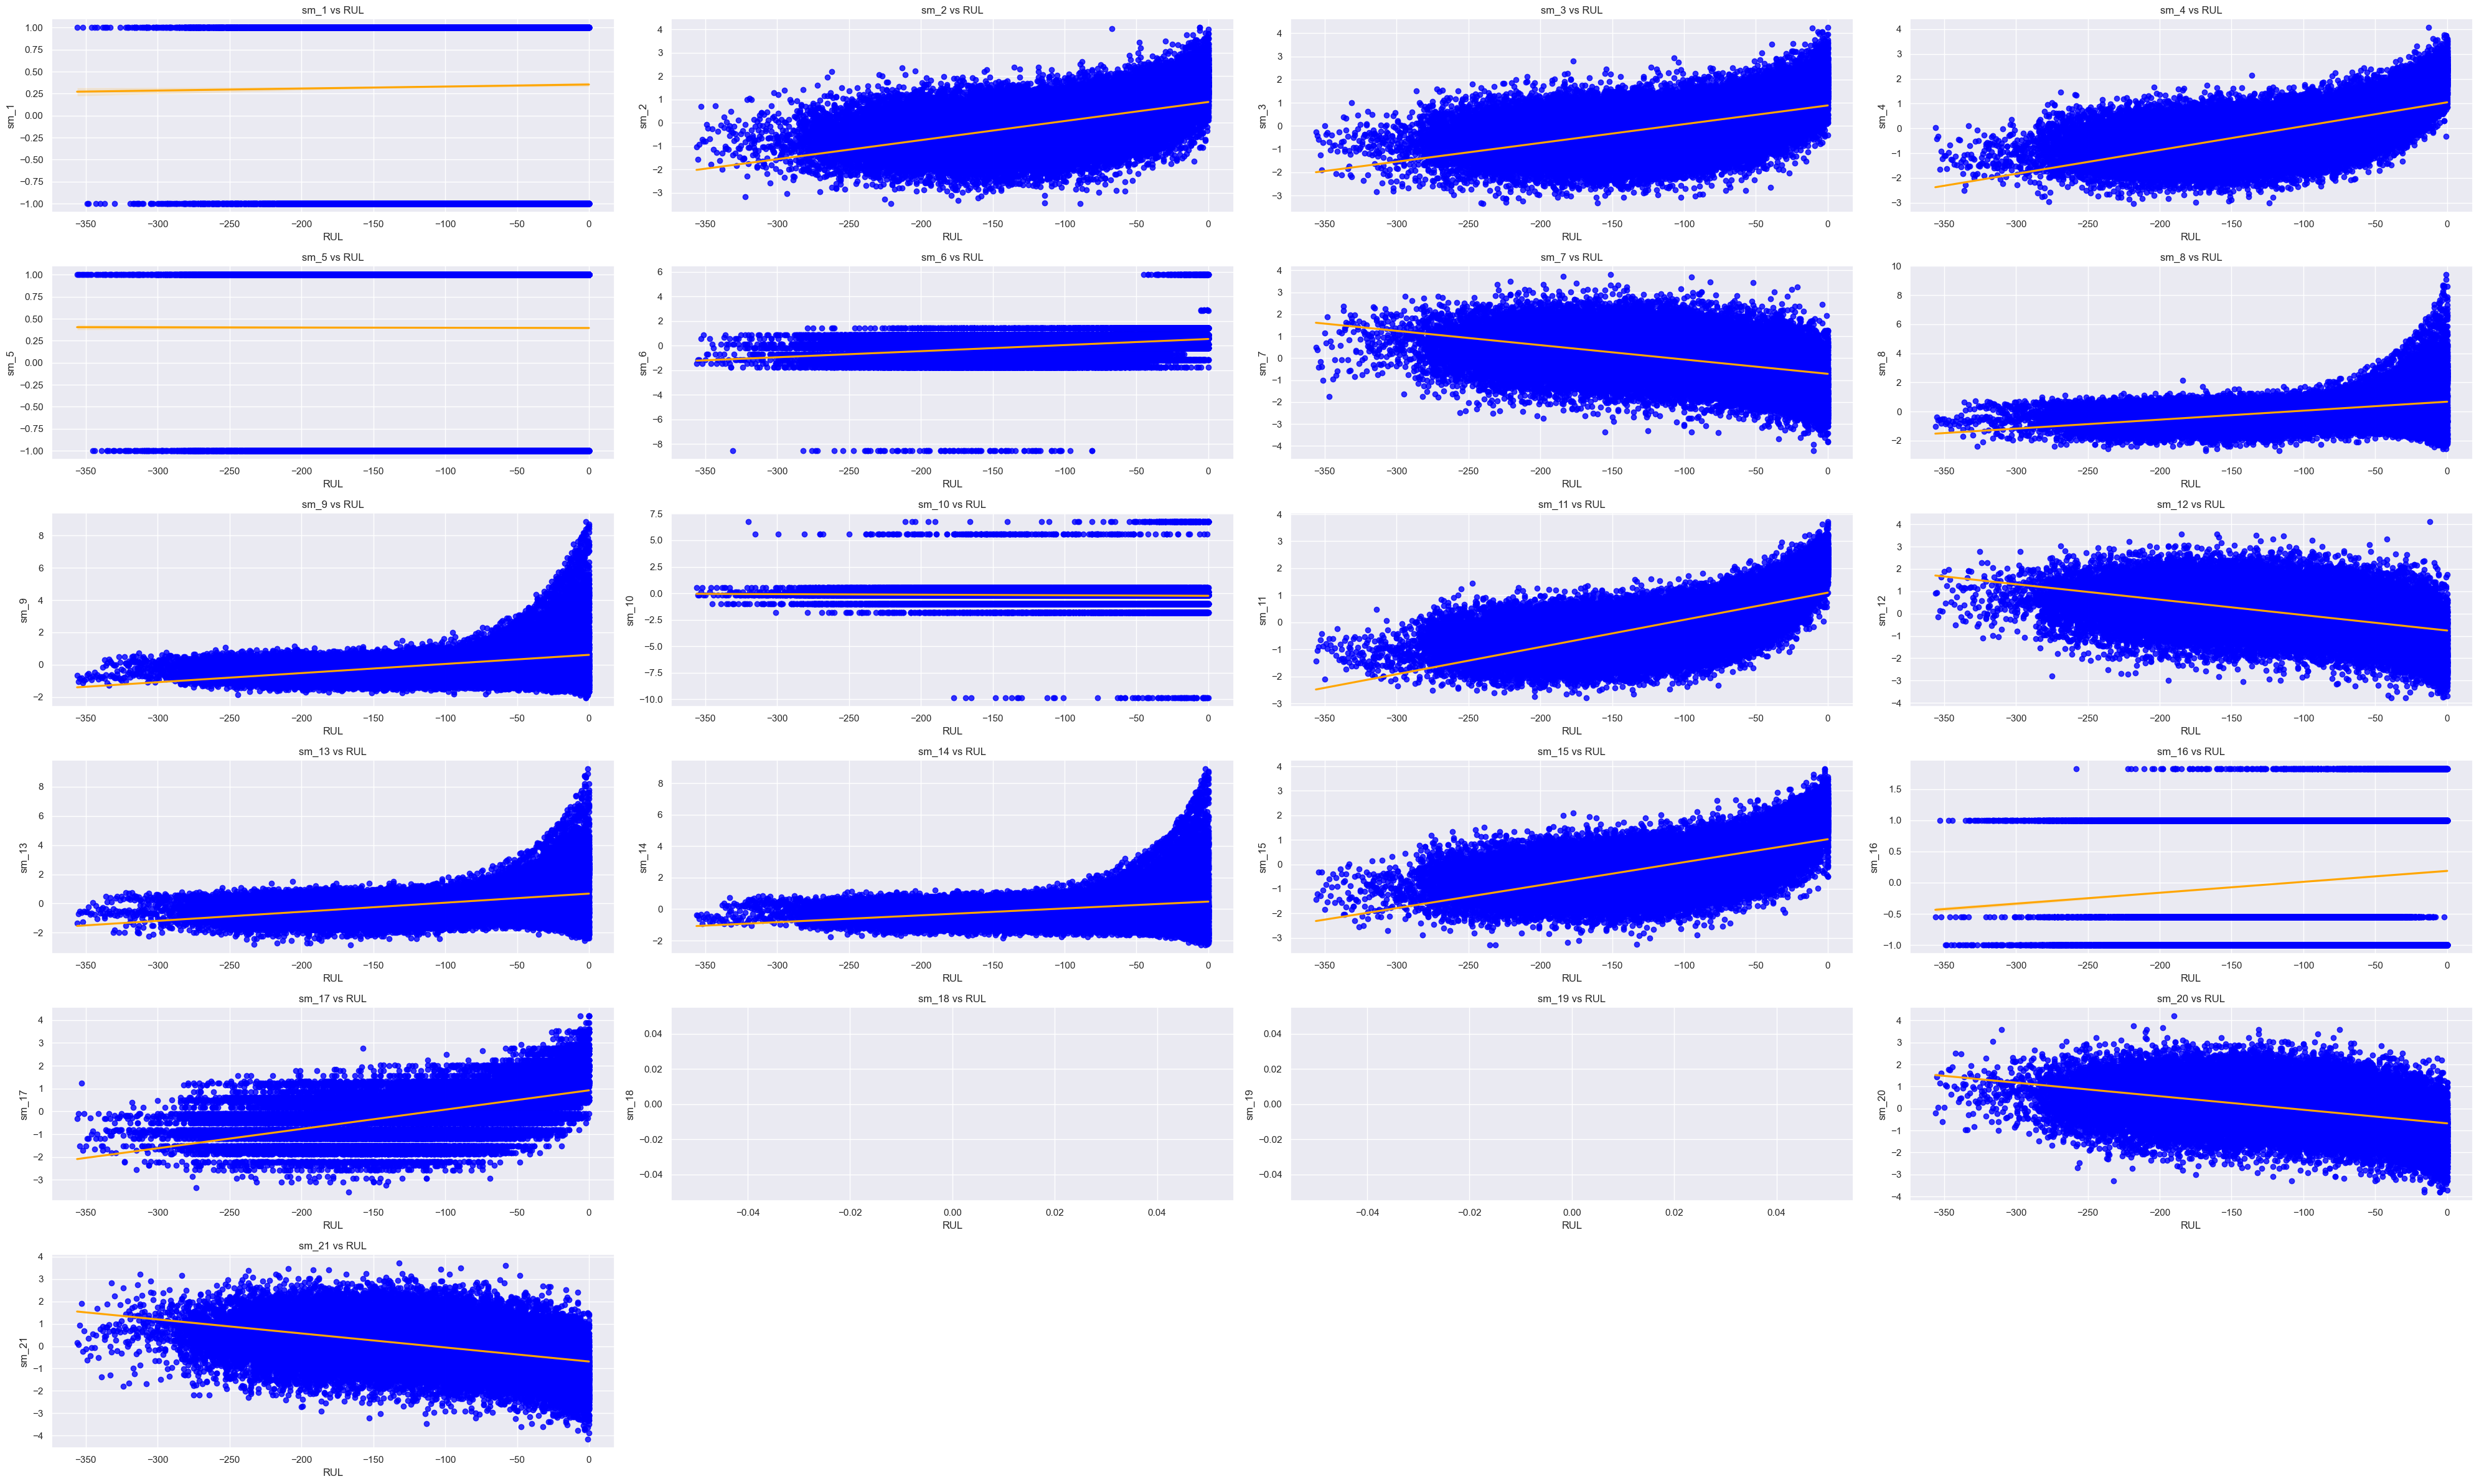

In [ ]:
num_cols = 4  # Número de columnas en la figura
num_rows = len(norm_train_df.columns[5:-2]) // num_cols + (len(norm_train_df.columns[5:-2]) % num_cols > 0)  # Se calcula el número de filas

fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 24))  # Se ajusta el tamaño de las sub figuras

# Se crean los scatter plots para cada sensor
for i, col in enumerate(norm_train_df.columns[5:-2]):  # Se excluye la columna del RUL
    row, col_pos = divmod(i, num_cols)  # Se calcula la posición de la subplot
    
    # Se grafica los scatterplots y la línea de tendencia
    sns.regplot(x=norm_train_df['RUL'], y=norm_train_df[col], ax=axs[row, col_pos],
                scatter_kws={'color': 'blue', 'marker': 'o'},  # Personalización del scatterplot
                line_kws={'color': 'orange'})  # Personalización de la línea de tendencia

    axs[row, col_pos].set_title(f'{col} vs RUL')  # Título del plot
    axs[row, col_pos].set_xlabel('RUL')  # Etiqueta del eje X
    axs[row, col_pos].set_ylabel(col)  # Etiqueta del eje Y

plt.tight_layout()

# Se remueven los plots vacíos en caso de ser necesario
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.show()  # Se muestra la figura

##### En estos gráficos se ve que los sensores 1, 5, 6 ,10 y 16 no tienen ninguna tendencia aparante hacia el final de la vida del motor.
##### Mientras que los sensores 18 y 19 no muestran nada al ser normalizados por la técnica de cluster scaling, por esto estos se van a eliminar.

In [25]:
# Eliminar las columnas específicadas anteriormente
data_df = train_df.drop(columns=['sm_1', 'sm_5', 'sm_6', 'sm_10', 'sm_16', 'sm_18', 'sm_19'])
data_df

,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21,RUL
0,1,1,10.0047,0.2501,20.0,604.13,1499.45,1309.95,394.88,2318.87,8770.20,45.40,372.15,2388.13,8120.83,8.6216,368,28.58,17.1735,-222
1,1,2,0.0015,0.0003,100.0,642.13,1584.55,1403.96,553.67,2388.01,9045.76,47.29,521.81,2388.15,8132.87,8.3907,391,38.99,23.3619,-221
2,1,3,34.9986,0.8401,60.0,555.42,1368.17,1122.49,194.93,2222.86,8343.91,41.92,183.26,2387.95,8063.84,9.3557,334,14.83,8.8555,-220
3,1,4,20.0031,0.7005,0.0,607.03,1488.44,1249.18,334.82,2323.85,8721.53,44.26,314.84,2388.07,8052.30,9.2231,364,24.42,14.7832,-219
4,1,5,42.0041,0.8405,40.0,549.52,1354.48,1124.32,138.24,2211.80,8314.56,41.79,130.44,2387.89,8083.67,9.2986,330,10.99,6.4025,-218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,551.02,1365.27,1147.43,137.97,2211.33,8303.20,42.68,130.21,2387.39,8062.87,9.4672,333,10.57,6.2985,-4
45914,218,130,42.0029,0.8415,40.0,550.07,1365.55,1142.21,137.56,2211.29,8302.69,42.62,130.24,2387.28,8062.05,9.4619,332,10.40,6.2741,-3
45915,218,131,41.9999,0.8400,40.0,549.92,1359.21,1150.15,138.05,2211.24,8309.41,42.83,129.86,2387.33,8062.73,9.4827,334,10.37,6.1978,-2
45916,218,132,35.0007,0.8419,60.0,556.55,1380.05,1145.49,194.59,2222.54,8330.67,42.61,182.03,2387.56,8043.21,9.4212,337,14.70,8.6761,-1


# Calcular el score del challenge

In [21]:
def phm08_score(true_rul, predicted_rul):
    """
    Calcular el score para un set de valores RUL predichos y reales
    
    Parameters:
    - true_rul: Arreglo de los valores RUL reales
    - predicted_rul: Arreglo de las predicciones
    
    Returns:
    - score: Score calculado
    """
    
    # Se inicializa el score
    score = 0
    # Se guardan los arreglos con los datos correspondientes
    true_rul = np.array(true_rul)
    predicted_rul = np.array(predicted_rul)
    
    # Se itera sobres estos valores
    for true, predict in zip(true_rul, predicted_rul):
        
        # Se revisa si la diferencia es mayor a cero
        if(predict-true<0):
            # Si sí se le añade el score el valor correspondiente a este
            score = score + (np.exp(-(predict - true) / 13) - 1)
        else:
            # Si no se le añade el valor correspondiente al caso contrario
            score = score + (np.exp((predict - true) / 10) - 1)
            
    return score

# Normalización min-max

In [26]:
# Se guardan las estadísticas de la columna de RUL sin normalizar
train_stats = train_df['RUL'].describe().transpose()

def norm(x, stats):
    """
    Normalizar los datos según la normalización min-max
    
    Parameters:
    - x: datos a normalizar
    - stats: estadísticas de estos datos
    
    Returns:
    - Datos normalizados
    """
    return((x-stats['min'])/(stats['max']-stats['min'])) #min-max norm

def reverse_norm(x):
    """
    Desnormalizar los datos según la normalización min-max
    
    Parameters:
    - x: datos a desnormalizar
    
    Returns:
    - Datos desnormalizados
    """
    return(x*(train_stats['max']-train_stats['min'])+train_stats['min'])

train_df = norm(train_df, train_df.describe().transpose())
train_stats

count    45918.000000
mean      -109.307396
std         68.420545
min       -356.000000
25%       -159.000000
50%       -105.000000
75%        -52.000000
max          0.000000
Name: RUL, dtype: float64

# Separar los datos en training y validation

In [27]:
# Separar los datos por ID.
unit_ids = train_df['unit_id'].unique()

# Se hacen dos grupos de datos, 80% test y 20% validación
train_engines, val_engines = train_test_split(unit_ids, test_size=0.2, random_state=42)

# Se acomodan los datos por ID
train_data = train_df[train_df['unit_id'].isin(train_engines)]
val_data = train_df[train_df['unit_id'].isin(val_engines)]

# Se quitan los IDs de los datos

train_data.pop('unit_id')
val_data.pop('unit_id')

# Se separan los labels de los set de datos de entrenamiento y validación

train_data = train_data.drop(columns=['time_cycle', 'oper_set1', 'oper_set2', 'oper_set3']) #, 'sm_1', 'sm_5', 'sm_6', 'sm_10', 'sm_16', 'sm_18', 'sm_19'
val_data = val_data.drop(columns=['time_cycle', 'oper_set1', 'oper_set2', 'oper_set3'])

train_label = train_data.pop('RUL')
val_label = val_data.pop('RUL')

val_data

,sm_1,sm_2,sm_3,sm_4,sm_5,sm_6,sm_7,sm_8,sm_9,sm_10,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
1903,0.626985,0.659864,0.643718,0.523288,0.507937,0.499371,0.472659,0.863889,0.601072,0.405405,...,0.471361,0.992562,0.493302,0.312008,0.0,0.652632,0.864693,1.0,0.487629,0.500764
1904,0.626985,0.660967,0.644937,0.525347,0.507937,0.499371,0.473399,0.863825,0.591154,0.405405,...,0.472046,0.992673,0.498311,0.310122,0.0,0.642105,0.864693,1.0,0.491409,0.496813
1905,1.000000,0.979776,0.932942,0.910432,1.000000,1.000000,0.996205,0.999197,0.861965,1.000000,...,0.995815,0.992507,0.662359,0.025750,1.0,0.936842,1.000000,1.0,0.980756,0.986469
1906,0.060269,0.183214,0.312001,0.227481,0.146592,0.144025,0.137552,0.650694,0.299432,0.243243,...,0.135711,0.992617,0.520093,0.352664,0.0,0.315789,0.651163,1.0,0.156701,0.162232
1907,1.000000,0.978029,0.919969,0.909778,1.000000,1.000000,0.994319,0.999366,0.865588,1.000000,...,0.995282,0.992700,0.678258,0.032713,1.0,0.926316,1.000000,1.0,0.983849,0.981671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45493,0.238089,0.017283,0.065677,0.091578,0.293184,0.208805,0.090937,0.001964,0.043181,0.027027,...,0.089493,0.002562,0.106664,0.958945,0.0,0.063158,0.000000,0.0,0.142268,0.135388
45494,0.626985,0.668321,0.664626,0.572238,0.507937,0.500000,0.470201,0.864649,0.620915,0.378378,...,0.469636,0.993719,0.537764,0.352374,1.0,0.673684,0.864693,1.0,0.485567,0.481479
45495,0.597937,0.643133,0.715543,0.735316,0.617180,0.615723,0.612454,0.853794,0.676823,0.891892,...,0.611511,0.993444,0.704741,0.155297,1.0,0.726316,0.854123,1.0,0.625086,0.615807
45496,1.000000,0.996139,0.960973,0.972970,1.000000,1.000000,0.989259,0.999810,0.900227,1.000000,...,0.989574,0.993141,0.739115,0.061111,1.0,0.989474,1.000000,1.0,0.968041,0.967075


In [28]:

# Los dataframes se convierten en arreglos de numpy
X_train = train_data.values  # (n_samples, n_features)
y_train = train_label.values.flatten()  # (n_samples)

time_steps = 200  # Longitud de la secuencia temporal

# Se crean las secuencias para los features y el label
X_train_seq = []
y_train_seq = []

for i in range(len(X_train) - time_steps):
    X_train_seq.append(X_train[i:i + time_steps]) # Secuencia de features
    y_train_seq.append(y_train[i + time_steps])  # El label para el siguiente paso de tiempo

X_train_seq = np.array(X_train_seq)  # (n_samples, time_steps, n_features)
y_train_seq = np.array(y_train_seq)  # (n_samples,)

# Se cambia la forma de los datos de entrada
n_samples = X_train_seq.shape[0]
X_train_flat = X_train_seq.reshape(n_samples, -1)  # (n_samples, time_steps * n_features)

#se vuelve a convertir las labels en una columna
y_train_seq = y_train_seq.reshape(-1, 1)

# Se hace lo mismo para el set de validación

X_val = val_data.values
y_val = val_label.values.flatten()

X_val_seq = []
y_val_seq = []

for i in range(len(X_val) - time_steps):
    X_val_seq.append(X_val[i:i + time_steps])
    y_val_seq.append(y_val[i + time_steps])

X_val_seq = np.array(X_val_seq)
y_val_seq = np.array(y_val_seq)

n_samples = X_val_seq.shape[0]
X_val_flat = X_val_seq.reshape(n_samples, -1)

y_val_seq = y_val_seq.reshape(-1, 1)

# Modelo

In [29]:
# Se definen los parámetros encontrados en la búsqueda automática

#leaking rate
lr = 0.6571588388986349

#spectral radius
sr = 3.650312480403175e-05

#cant de neuronas
units = 150

#ridge
ridge = 1.0243845988173443

# Se crea la capa de datos 
data = Input()

# Se crea el resevoir y ridge del modelo
reservoir = Reservoir(units, lr, sr, input_scaling=1.0, seed=1234)
readout = Ridge(ridge=ridge)

reservoir <<= readout #conexión entre la salida y el reservoir (feedback)
esn_model = data >> reservoir >> readout & data >> readout

In [30]:
# Entrenamiento del modelo

try:
    esn_model.fit(X_train_flat, y_train_seq, force_teachers=True)
    print("Modelo entrenado exitosamente.")
except Exception as e:
    print("Error al entrenar el modelo:", e)

# Verificar el estado de inicialización
print(reservoir.is_initialized, readout.is_initialized)

Running Model-7: 36220it [00:10, 3435.95it/s]?, ?it/s]
Running Model-7: 100%|██████████| 1/1 [00:14<00:00, 14.45s/it]


Fitting node Ridge-1...
Modelo entrenado exitosamente.
True True


# Optimización de Hiperparámetros

In [14]:
from reservoirpy.observables import nrmse, rsquare, mse

# Se define el objetivo de la función a optimizar

def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    x_train, y_train, x_test, y_test = dataset
    
    # Se puede acceder a todo lo que pongas en el archivo de configuración desde el parámetro 'config'.
    instances = config["instances_per_trial"]
    
    # Se cambia la seed en cada instancia para que no haya sesgo de inicialización del modelo.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Se crea el modelo dependiendo de los parámetros seleccionados
        reservoir = Reservoir(
            units=N, 
            sr=sr, 
            lr=lr, 
            input_scaling=input_scaling, 
            seed=variable_seed
        )

        data = Input()
        readout = Ridge(ridge=ridge)

        reservoir <<= readout #conexión entre la salida y el reservoir (feedback)
        model = data >> reservoir >> readout & data >> readout


        # Se entrena y prueba el modelo
        predictions = model.fit(x_train, y_train)\
                            .run(x_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)
        
        # Se cambia la seed en cada instancia
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Se retorna un diccionario de métrica. La 'pérdida' es mandadoria cuando se usa hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [ ]:
# Se definen los parámetros a optimizar y sus límites
hyperopt_config = {
    "exp": "hyperopt-RUL",    # EL nombre del experimento
    "hp_max_evals": 150,              # la cantidad de sets de parámetros a testear
    "hp_method": "random",            # el método utilizado (random search)
    "seed": 42,                       # la seed, se mantiene igual para mantener reproducibilidad
    "instances_per_trial": 4,         # cuantos modelos aleatorios se prueban por conjunto de parámetros
    "hp_space": {                     # los rangos de los parámetros
        "N": ["choice", 50 ,150, 200, 300], # el número de neuronas se prueban diferentes valores
        "sr": ["loguniform", 1e-6, 10],   # el radio espectral es log uniforme entre 1e-6 y 10
        "lr": ["loguniform", 1e-3, 1],    # igual el leaking rate, pero entre 1e-3 y 1
        "input_scaling": ["choice", 1.0], # el escalamiento es fijo
        "ridge": ["loguniform", 1e-8, 1e1], # el ridge es log uniforme entre 1e-8 y 1e1
        "seed": ["choice", 1234]
    }
}

# Se guarda la configuración en un archivo json
# cada archivo empieza con un número correspondiente al número de experimento
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)
    
# Se preparan los datos 
dataset = (X_train_flat, y_train_seq, X_val_flat, y_val_seq)

In [ ]:
# Se corre la búsqueda
from reservoirpy.hyper import research
best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

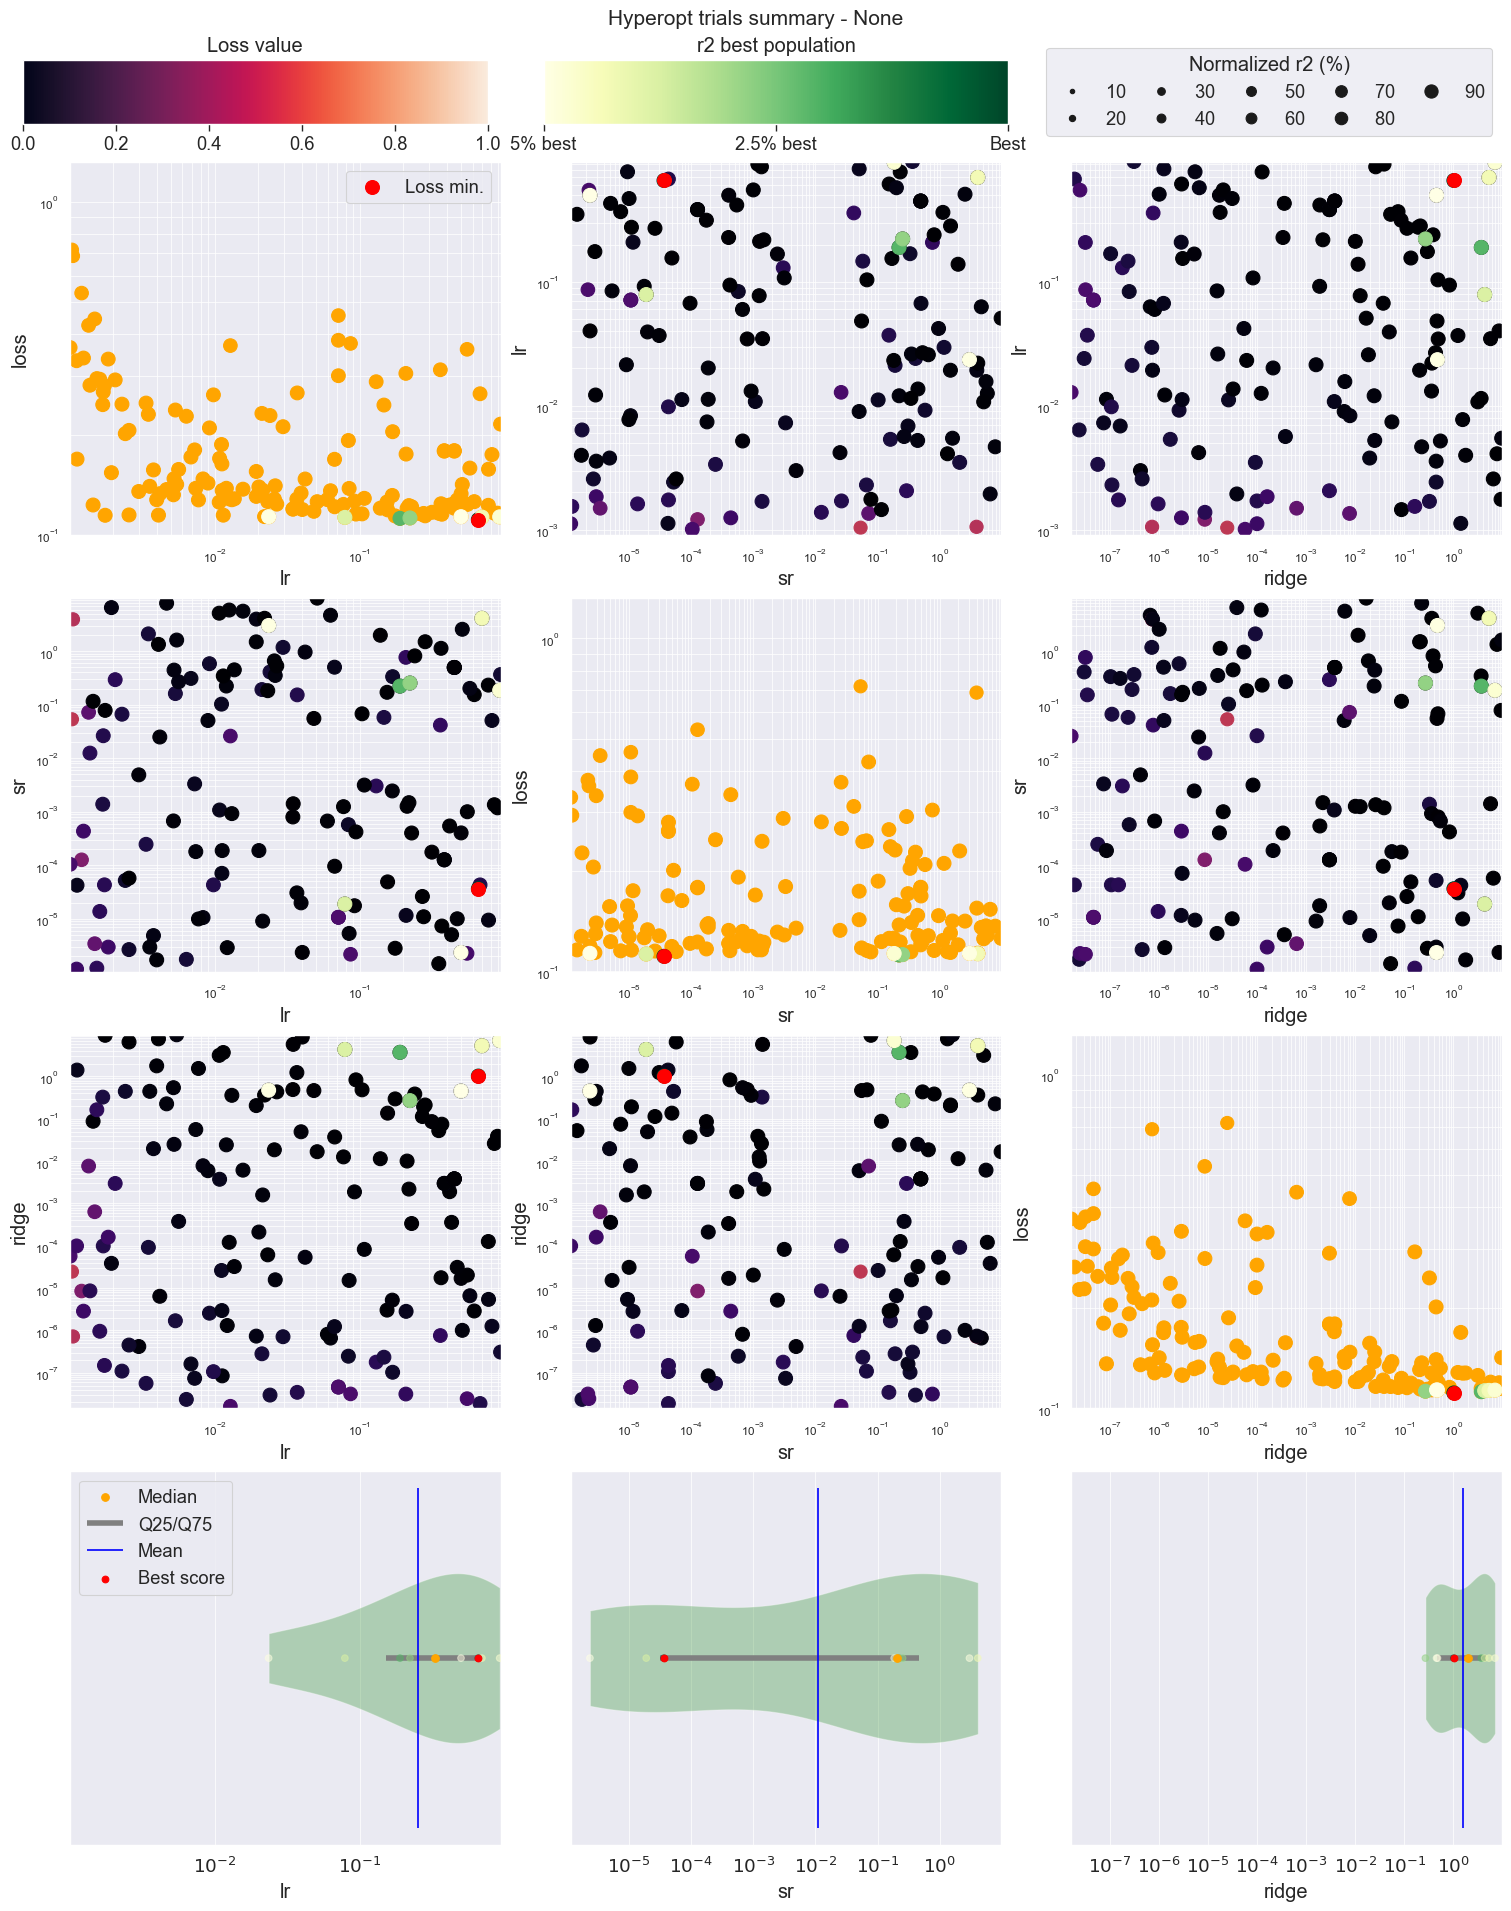

In [16]:
# Se muestran los resultados
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")

# Hacer predicciones

In [ ]:
# Hacer Predicciones
y_pred = esn_model.run(X_val_flat, forced_feedbacks=y_val_seq)
y_test = y_val_seq

# Se desnormalizan las predicciones
denorm_y_test = reverse_norm(y_test)
denorm_y_pred = reverse_norm(y_pred)

# Se calcula el score con la función creada anteriormente
print(phm08_score(denorm_y_test, denorm_y_pred))

# Se calcula el MSE y RMSE
print(mse(y_true=denorm_y_test, y_pred=denorm_y_pred))
print(rmse(y_true=denorm_y_test, y_pred=denorm_y_pred))

Running Model-7: 9298it [00:02, 3485.99it/s]          


[5.30348644e+13]
1705.9181288871248
41.30276175859339


# Hacer predicciones con los datos del profesor

In [66]:
# Importar los datos desde el csv

# Guarda los nombres únicos de las primeras dos columnas.
index_col_names=['unit_id','time_cycle']
# Genera los nombres del primer set de columnas con formato, estas son las de operational setting n.
operat_set_col_names=['oper_set{}'.format(i) for i in range(1,4)]
# Genera los nombres del segundo set de columnas con formato, estas son las de sensor measurement n.
sensor_measure_col_names=['sm_{}'.format(i) for i in range(1,22)]
# Pone todos los títulos en una lista
all_col=index_col_names+operat_set_col_names+sensor_measure_col_names

# Importa los datos desde el .csv con su nombre de columna en un dataframe.
profe_df=pd.read_csv('Datos para validación de modelo y competencia.csv',delimiter=',',names=all_col)
profe_df

,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,10.0065,0.2501,20.0,489.05,604.44,1492.89,1300.86,10.52,...,371.72,2388.09,8142.73,8.6019,0.03,368,2319,100.00,28.70,17.1601
1,1,2,35.0078,0.8416,60.0,449.44,555.42,1362.38,1126.59,5.48,...,183.43,2388.29,8079.21,9.2750,0.02,333,2223,100.00,14.80,8.9987
2,1,3,10.0033,0.2506,20.0,489.05,604.03,1496.74,1299.65,10.52,...,372.23,2388.02,8145.89,8.6357,0.03,368,2319,100.00,28.62,17.2334
3,1,4,0.0003,0.0018,100.0,518.67,642.46,1589.40,1398.69,14.62,...,522.37,2387.99,8149.33,8.3974,0.03,391,2388,100.00,39.03,23.4233
4,1,5,0.0005,0.0013,100.0,518.67,642.21,1587.15,1396.20,14.62,...,523.08,2388.01,8151.81,8.3813,0.03,392,2388,100.00,39.11,23.3709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,10,81,0.0003,0.0000,100.0,518.67,643.35,1594.87,1417.80,14.62,...,520.59,2388.05,8208.13,8.5039,0.03,394,2388,100.00,38.62,23.0967
1369,10,82,42.0009,0.8400,40.0,445.00,550.68,1356.82,1144.91,3.91,...,130.53,2389.43,8168.41,9.3686,0.02,334,2212,100.00,10.52,6.3149
1370,10,83,20.0021,0.7000,0.0,491.19,608.20,1490.49,1258.19,9.35,...,314.08,2388.81,8136.78,9.2918,0.03,368,2324,100.00,24.19,14.6694
1371,10,84,25.0050,0.6200,80.0,462.54,537.11,1265.43,1059.60,7.05,...,164.44,2029.63,7943.50,10.9619,0.02,308,1915,84.93,14.09,8.4710


In [67]:
# Calcular el RUL

# Primero se encuentra el ciclo de tiempo máximo para cada motor.
max_time_cycle=profe_df.groupby('unit_id')['time_cycle'].max()

rul = pd.DataFrame(max_time_cycle).reset_index()
rul.columns = ['unit_id', 'max']

# Se calcula el RUL para cada fila con un id específico y se le resta el máximo.
profe_df = profe_df.merge(rul, on=['unit_id'], how='left')
profe_df['RUL'] = profe_df['time_cycle'] - profe_df['max']
profe_df.drop('max', axis=1, inplace=True)
profe_df[profe_df.unit_id==1].iloc[:,[1,-1]]
profe_df

,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21,RUL
0,1,1,10.0065,0.2501,20.0,489.05,604.44,1492.89,1300.86,10.52,...,2388.09,8142.73,8.6019,0.03,368,2319,100.00,28.70,17.1601,-179
1,1,2,35.0078,0.8416,60.0,449.44,555.42,1362.38,1126.59,5.48,...,2388.29,8079.21,9.2750,0.02,333,2223,100.00,14.80,8.9987,-178
2,1,3,10.0033,0.2506,20.0,489.05,604.03,1496.74,1299.65,10.52,...,2388.02,8145.89,8.6357,0.03,368,2319,100.00,28.62,17.2334,-177
3,1,4,0.0003,0.0018,100.0,518.67,642.46,1589.40,1398.69,14.62,...,2387.99,8149.33,8.3974,0.03,391,2388,100.00,39.03,23.4233,-176
4,1,5,0.0005,0.0013,100.0,518.67,642.21,1587.15,1396.20,14.62,...,2388.01,8151.81,8.3813,0.03,392,2388,100.00,39.11,23.3709,-175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,10,81,0.0003,0.0000,100.0,518.67,643.35,1594.87,1417.80,14.62,...,2388.05,8208.13,8.5039,0.03,394,2388,100.00,38.62,23.0967,-4
1369,10,82,42.0009,0.8400,40.0,445.00,550.68,1356.82,1144.91,3.91,...,2389.43,8168.41,9.3686,0.02,334,2212,100.00,10.52,6.3149,-3
1370,10,83,20.0021,0.7000,0.0,491.19,608.20,1490.49,1258.19,9.35,...,2388.81,8136.78,9.2918,0.03,368,2324,100.00,24.19,14.6694,-2
1371,10,84,25.0050,0.6200,80.0,462.54,537.11,1265.43,1059.60,7.05,...,2029.63,7943.50,10.9619,0.02,308,1915,84.93,14.09,8.4710,-1


In [68]:
# Normalizar los datos

profe_norm = norm(profe_df, profe_df.describe().transpose())
profe_norm

,unit_id,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21,RUL
0,0.0,0.000000,0.238205,0.297031,0.2,0.597937,0.636431,0.683692,0.667657,0.617180,...,0.995660,0.809047,0.089102,1.0,0.688172,0.854123,1.0,0.637150,0.634219,0.011050
1,0.0,0.005525,0.833360,0.999525,0.6,0.060269,0.181784,0.319627,0.232418,0.146592,...,0.996213,0.627659,0.343987,0.0,0.311828,0.651163,1.0,0.156347,0.162484,0.016575
2,0.0,0.011050,0.238128,0.297625,0.2,0.597937,0.632628,0.694432,0.664635,0.617180,...,0.995466,0.818070,0.101901,1.0,0.688172,0.854123,1.0,0.634383,0.638456,0.022099
3,0.0,0.016575,0.000007,0.002138,1.0,1.000000,0.989056,0.952912,0.911988,1.000000,...,0.995384,0.827893,0.011663,1.0,0.935484,1.000000,1.0,0.994466,0.996237,0.027624
4,0.0,0.022099,0.000012,0.001544,1.0,1.000000,0.986737,0.946636,0.905769,1.000000,...,0.995439,0.834975,0.005566,1.0,0.946237,1.000000,1.0,0.997233,0.993208,0.033149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,1.0,0.441989,0.000007,0.000000,1.0,1.000000,0.997310,0.968171,0.959715,1.000000,...,0.995549,0.995802,0.051992,1.0,0.967742,1.000000,1.0,0.980284,0.977359,0.977901
1369,1.0,0.447514,0.999831,0.997625,0.4,0.000000,0.137822,0.304117,0.278172,0.000000,...,0.999364,0.882378,0.379430,0.0,0.322581,0.627907,1.0,0.008302,0.007358,0.983425
1370,1.0,0.453039,0.476150,0.831354,0.0,0.626985,0.671304,0.676997,0.561089,0.507937,...,0.997650,0.792056,0.350348,1.0,0.688172,0.864693,1.0,0.481148,0.490255,0.988950
1371,1.0,0.458564,0.595244,0.736342,0.8,0.238089,0.011964,0.049180,0.065110,0.293184,...,0.004755,0.240127,0.982770,0.0,0.043011,0.000000,0.0,0.131788,0.131982,0.994475


In [69]:
# Separar las etiquetas de los features
profe_label = profe_norm.pop('RUL')

profe_norm = profe_norm.drop(columns=['unit_id', 'time_cycle', 'oper_set1', 'oper_set2', 'oper_set3', 'sm_1', 'sm_5', 'sm_6', 'sm_10', 'sm_16', 'sm_18', 'sm_19'])

profe_norm

,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21
0,0.636431,0.683692,0.667657,0.616864,0.853358,0.682309,0.756780,0.615408,0.995660,0.809047,0.089102,0.688172,0.637150,0.634219
1,0.181784,0.319627,0.232418,0.136103,0.651068,0.316116,0.450847,0.136980,0.996213,0.627659,0.343987,0.311828,0.156347,0.162484
2,0.632628,0.694432,0.664635,0.616793,0.853210,0.685094,0.745763,0.616704,0.995466,0.818070,0.101901,0.688172,0.634383,0.638456
3,0.989056,0.952912,0.911988,0.998828,0.999239,0.938557,0.917797,0.998196,0.995384,0.827893,0.011663,0.935484,0.994466,0.996237
4,0.986737,0.946636,0.905769,0.999210,0.999324,0.936199,0.918644,1.000000,0.995439,0.834975,0.005566,0.946237,0.997233,0.993208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,0.997310,0.968171,0.959715,0.993659,0.999514,1.000000,0.977119,0.993673,0.995549,0.995802,0.051992,0.967742,0.980284,0.977359
1369,0.137822,0.304117,0.278172,0.003972,0.630047,0.356135,0.525424,0.002566,0.999364,0.882378,0.379430,0.322581,0.008302,0.007358
1370,0.671304,0.676997,0.561089,0.471454,0.865400,0.709816,0.729661,0.468950,0.997650,0.792056,0.350348,0.688172,0.481148,0.490255
1371,0.011964,0.049180,0.065110,0.090831,0.003465,0.069901,0.050000,0.088729,0.004755,0.240127,0.982770,0.043011,0.131788,0.131982


In [74]:
# Hacer secuencias temporales con los datos

# Los dataframes se convierten en arreglos de numpy
X_profe = profe_norm.values  # (n_samples, n_features)
y_profe = profe_label.values.flatten()  # (n_samples)

time_steps =300  # Longitud de la secuencia temporal

# Se crean las secuencias para los features y el label
X_val_seq_profe = []
y_val_seq_profe = []

for i in range(len(X_profe) - time_steps):
    X_val_seq_profe.append(X_profe[i:i + time_steps]) # Secuencia de features
    y_val_seq_profe.append(y_profe[i + time_steps])  # El label para el siguiente paso de tiempo

X_val_seq_profe = np.array(X_val_seq_profe)  # (n_samples, time_steps, n_features)
y_val_seq_profe = np.array(y_val_seq_profe)  # (n_samples,)

# Se cambia la forma de los datos de entrada
n_samples = X_val_seq_profe.shape[0]
X_val_flat_profe = X_val_seq_profe.reshape(n_samples, -1)  # (n_samples, time_steps * n_features)

#se vuelve a convertir las labels en una columna
y_val_seq_profe = y_val_seq_profe.reshape(-1, 1)

In [ ]:
# Hacer Predicciones
y_pred_profe = esn_model.run(X_val_flat_profe, forced_feedbacks=y_val_seq_profe)
y_test_profe = y_val_seq_profe

# Se desnormalizan las predicciones
denorm_y_test_profe = reverse_norm(y_test_profe)
denorm_y_pred_profe = reverse_norm(y_pred_profe)

# Se calcula el score con la función creada anteriormente
print(phm08_score(denorm_y_test_profe, denorm_y_pred_profe))

# Hacer dataframes con los datos predichos y los valores calculados
y_test_df = pd.DataFrame(denorm_y_test_profe, columns=['RUL_Real'])
y_pred_df = pd.DataFrame(denorm_y_pred_profe, columns=['RUL_Pred'])

# Se calcula el MSE y RMSE
print(mse(y_true=denorm_y_test_profe, y_pred=denorm_y_pred_profe))
print(rmse(y_true=denorm_y_test_profe, y_pred=denorm_y_pred_profe))

Running Model-7: 1073it [00:00, 3470.59it/s]          

[2.05040305e+64]
430443.09540778684
656.081622519475
